<a href="https://colab.research.google.com/github/karthikpuranik11/Constraint2021/blob/main/biLSTM_with_GloVe_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
train = pd.read_csv('/content/Constraint_English_Train - Sheet1.csv',#delimiter=',',
                 header=None,names=['id','tweet','label'])
train = train.drop(columns='id')
train= train[1:]
train.label = train.label.apply({'fake':0,'real':1}.get)
train.head(10) 

,tweet,label
1,The CDC currently reports 99031 deaths. In gen...,1
2,States reported 1121 deaths a small rise from ...,1
3,Politically Correct Woman (Almost) Uses Pandem...,0
4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
5,Populous states can generate large case counts...,1
6,"Covid Act Now found ""on average each person in...",1
7,If you tested positive for #COVID19 and have n...,1
8,Obama Calls Trump’s Coronavirus Response A Cha...,0
9,"???Clearly, the Obama administration did not l...",0
10,Retraction—Hydroxychloroquine or chloroquine w...,0


In [3]:
test=pd.read_csv('/content/english_test_with_labels - Sheet1.csv')
test.label = test.label.apply({'fake':0,'real':1}.get)
test

,id,tweet,label
0,1,Our daily update is published. States reported...,1
1,2,Alfalfa is the only cure for COVID-19.,0
2,3,President Trump Asked What He Would Do If He W...,0
3,4,States reported 630 deaths. We are still seein...,1
4,5,This is the sixth time a global health emergen...,1
...,...,...,...
2135,2136,#CoronaVirusUpdates: State-wise details of Tot...,1
2136,2137,Tonight 12(midnight) onwards Disaster Manageme...,0
2137,2138,296 new cases of #COVID19Nigeria; Plateau-85 E...,1
2138,2139,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,1


In [4]:
val = pd.read_csv('/content/Constraint_English_Test - Sheet1.csv')
val = val.drop(columns='id')
#val = val[1:]
val['label']=test['label']
val

,tweet,label
0,Our daily update is published. States reported...,1
1,Alfalfa is the only cure for COVID-19.,0
2,President Trump Asked What He Would Do If He W...,0
3,States reported 630 deaths. We are still seein...,1
4,This is the sixth time a global health emergen...,1
...,...,...
2135,#CoronaVirusUpdates: State-wise details of Tot...,1
2136,Tonight 12(midnight) onwards Disaster Manageme...,0
2137,296 new cases of #COVID19Nigeria; Plateau-85 E...,1
2138,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,1


In [5]:
import nltk
from nltk.tokenize import TweetTokenizer
def tokenizer(df):
    tknzr = TweetTokenizer(strip_handles=True)
    df['tweet']= df['tweet'].apply(lambda x: tknzr.tokenize(x))
    print(df)
    
tokenizer(val)
tokenizer(train)

                                                  tweet  label
0     [Our, daily, update, is, published, ., States,...      1
1     [Alfalfa, is, the, only, cure, for, COVID, -, ...      0
2     [President, Trump, Asked, What, He, Would, Do,...      0
3     [States, reported, 630, deaths, ., We, are, st...      1
4     [This, is, the, sixth, time, a, global, health...      1
...                                                 ...    ...
2135  [#CoronaVirusUpdates, :, State-wise, details, ...      1
2136  [Tonight, 12, (, midnight, ), onwards, Disaste...      0
2137  [296, new, cases, of, #COVID19Nigeria, ;, Plat...      1
2138  [RT, :, #DYK, ?, ’, s, One-Stop, Shop, for, #C...      1
2139  [More, than, half, of, pregnant, women, recent...      1

[2140 rows x 2 columns]
                                                  tweet  label
1     [The, CDC, currently, reports, 99031, deaths, ...      1
2     [States, reported, 1121, deaths, a, small, ris...      1
3     [Politically, Correct, W

In [6]:
import re
def clean(df):
    df['tweet']=df['tweet'].apply(lambda x: [i for i in x if not re.match('[^\w\s]',i) and len(i)>3])
    print(df)
clean(train)
clean(val)

                                                  tweet  label
1     [currently, reports, 99031, deaths, general, d...      1
2     [States, reported, 1121, deaths, small, rise, ...      1
3     [Politically, Correct, Woman, Almost, Uses, Pa...      0
4     [have, 1524, testing, laboratories, India, 25t...      1
5     [Populous, states, generate, large, case, coun...      1
...                                                 ...    ...
6416  [tiger, tested, positive, COVID, please, stay,...      0
6417  [Autopsies, prove, that, COVID, blood, clot, p...      0
6418  [post, claims, COVID, vaccine, already, been, ...      0
6419         [Aamir, Khan, Donate, Relief, Cares, Fund]      0
6420  [been, days, since, last, case, COVID, acquire...      1

[6420 rows x 2 columns]
                                                  tweet  label
0     [daily, update, published, States, reported, 7...      1
1                          [Alfalfa, only, cure, COVID]      0
2     [President, Trump, Asked

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [8]:
from nltk.stem import PorterStemmer
from textblob import Word
st = PorterStemmer()
def stemnlemm(df):
    df['tweet']=df['tweet'].apply(lambda x: [Word(st.stem(i)).lemmatize() for i in x])
    print(df)
stemnlemm(train)
stemnlemm(val)

                                                  tweet  label
1     [current, report, 99031, death, gener, discrep...      1
2     [state, report, 1121, death, small, rise, from...      1
3     [polit, correct, woman, almost, use, pandem, e...      0
4     [have, 1524, test, laboratori, india, 25th, au...      1
5     [popul, state, gener, larg, case, count, look,...      1
...                                                 ...    ...
6416  [tiger, test, posit, covid, plea, stay, away, ...      0
6417  [autopsi, prove, that, covid, blood, clot, pne...      0
6418  [post, claim, covid, vaccin, alreadi, been, de...      0
6419           [aamir, khan, donat, relief, care, fund]      0
6420  [been, day, sinc, last, case, covid, acquir, l...      1

[6420 rows x 2 columns]
                                                  tweet  label
0     [daili, updat, publish, state, report, 734k, t...      1
1                          [alfalfa, onli, cure, covid]      0
2     [presid, trump, ask, wha

In [9]:
import nltk
from nltk.corpus import stopwords
stop=stopwords.words("english")
def stop_words(df):
    df['tweet']=df['tweet'].apply(lambda x: [i.lower() for i in x if i not in stop])
    print(df)
stop_words(train)
stop_words(val)

                                                  tweet  label
1     [current, report, 99031, death, gener, discrep...      1
2     [state, report, 1121, death, small, rise, last...      1
3     [polit, correct, woman, almost, use, pandem, e...      0
4     [1524, test, laboratori, india, 25th, august, ...      1
5     [popul, state, gener, larg, case, count, look,...      1
...                                                 ...    ...
6416  [tiger, test, posit, covid, plea, stay, away, ...      0
6417  [autopsi, prove, covid, blood, clot, pneumonia...      0
6418  [post, claim, covid, vaccin, alreadi, develop,...      0
6419           [aamir, khan, donat, relief, care, fund]      0
6420  [day, sinc, last, case, covid, acquir, local, ...      1

[6420 rows x 2 columns]
                                                  tweet  label
0     [daili, updat, publish, state, report, 734k, t...      1
1                          [alfalfa, onli, cure, covid]      0
2     [presid, trump, ask, wou

In [10]:
max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(train['tweet'].values)
tokenizer.fit_on_texts(val['tweet'].values)
X_train = tokenizer.texts_to_sequences(train['tweet'].values)
X_test = tokenizer.texts_to_sequences(val['tweet'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding = 'post', maxlen=max_len)
X_test = pad_sequences(X_test,padding = 'post', maxlen=max_len)

In [11]:
#X_train=train['tweet']
Y_train=train['label']
#X_test=val['tweet']
Y_test=val['label']
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6420, 512) (6420,)
(2140, 512) (2140,)


In [12]:
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import backend as K

class attention(Layer):
    def __init__(self):
        super(attention,self).__init__()

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [13]:
!wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c

--2020-12-19 18:49:42--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-19 18:49:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.21MB/s    in 6m 27s  

2020-12-19 18:56:09 (2.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [14]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [16]:
 from numpy import asarray
 from numpy import zeros

 embeddings_index = dict()

 glove_file = open('glove.6B.100d.txt', encoding="utf8")

 for line in glove_file:
     records = line.split()
     word = records[0]
     vector_dimensions = asarray(records[1:], dtype='float32')
     embeddings_index[word] = vector_dimensions
 glove_file.close()

 print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [17]:
word_index = tokenizer.word_index
print(len(word_index))


num_words = min(max_features, len(word_index)) + 1
print(num_words)

embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

16112
2001


In [18]:
K.clear_session()
from keras.regularizers import l2
from keras.initializers import Constant
embed_dim = 100
lstm_out = 128
# model = Sequential()
inputs = Input(shape=(512,))
x = Embedding(num_words, embed_dim,embeddings_initializer=Constant(embedding_matrix),input_length = X_train.shape[1])(inputs)
att_in = Bidirectional(LSTM(lstm_out,return_sequences=True, dropout=0.2))(x)
att_out = attention()(att_in)
d = Dropout(0.2)(att_out)
outputs = Dense(1, activation='sigmoid')(d)
model = Model(inputs,outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 100)          200100    
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 256)          234496    
_________________________________________________________________
attention (attention)        (None, 256)               768       
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 435,621
Trainable params: 435,621
Non-trainable params: 0
_______________________________________________________

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [44]:
history = model.fit(X_train, Y_train, batch_size = 180, validation_data=(X_test,Y_test), epochs=50, verbose=2)

Epoch 1/50
36/36 - 5s - loss: 0.1181 - accuracy: 0.9570 - val_loss: 0.3244 - val_accuracy: 0.8902
Epoch 2/50
36/36 - 5s - loss: 0.1117 - accuracy: 0.9607 - val_loss: 0.3173 - val_accuracy: 0.8949
Epoch 3/50
36/36 - 5s - loss: 0.1023 - accuracy: 0.9636 - val_loss: 0.3291 - val_accuracy: 0.8916
Epoch 4/50
36/36 - 5s - loss: 0.1030 - accuracy: 0.9646 - val_loss: 0.3448 - val_accuracy: 0.8916
Epoch 5/50
36/36 - 5s - loss: 0.0959 - accuracy: 0.9679 - val_loss: 0.3330 - val_accuracy: 0.8958
Epoch 6/50
36/36 - 5s - loss: 0.0982 - accuracy: 0.9648 - val_loss: 0.3210 - val_accuracy: 0.8995
Epoch 7/50
36/36 - 5s - loss: 0.0894 - accuracy: 0.9710 - val_loss: 0.3097 - val_accuracy: 0.9014
Epoch 8/50
36/36 - 5s - loss: 0.0878 - accuracy: 0.9684 - val_loss: 0.3308 - val_accuracy: 0.9005
Epoch 9/50
36/36 - 5s - loss: 0.0864 - accuracy: 0.9702 - val_loss: 0.3404 - val_accuracy: 0.8949
Epoch 10/50
36/36 - 5s - loss: 0.0794 - accuracy: 0.9734 - val_loss: 0.3353 - val_accuracy: 0.8986
Epoch 11/50
36/36 -

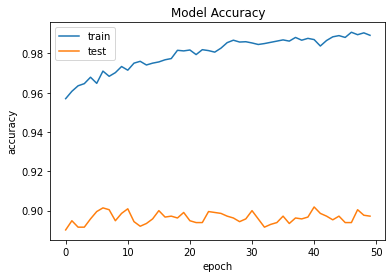

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [46]:
score = model.evaluate(X_test,Y_test,verbose=1)
predictions = np.argmax(model.predict(X_test),axis = -1)

print("Test score is {}".format(score[0]))
print("Test Accuracy is {}".format(score[1]))

67/67 [==============================] - 1s 21ms/step - loss: 0.4911 - accuracy: 0.8972
Test score is 0.49112993478775024
Test Accuracy is 0.8971962332725525


In [47]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)

In [48]:
rounded_predictions = np.argmax(model.predict(X_test, batch_size=128, verbose=0),axis = -1)

In [49]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, rounded_predictions))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1020
           1       0.00      0.00      0.00      1120

    accuracy                           0.48      2140
   macro avg       0.24      0.50      0.32      2140
weighted avg       0.23      0.48      0.31      2140



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, rounded_predictions)
print(score)

0.4766355140186916
